# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

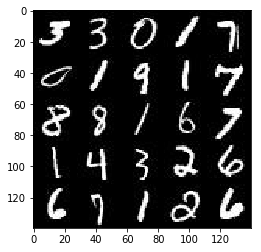

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

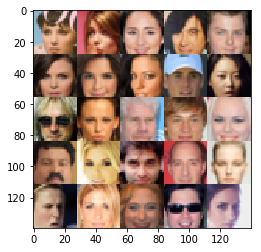

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.12.0


/home/thiago/miniconda3/envs/dog-project/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [82]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_input = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name='real_input')
    z_input = tf.placeholder(tf.float32, shape=(None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='lr', shape=())

    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [71]:
def discriminator(images, reuse=False, alpha=0.9):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [72]:
def generator(z, out_channel_dim, is_train=True, reuse=False, alpha=0.9):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 28x28x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=1, padding='same')
        # 28x28xout_channel_dim now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [33]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [34]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [35]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [96]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    _, image_width, image_height, image_channels = data_shape
    
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    samples, losses = [], []
    steps = 0    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={
                    input_real: batch_images, 
                    input_z: batch_z, 
                    lr: learning_rate
                })
                _ = sess.run(g_opt, feed_dict={
                    input_real: batch_images, 
                    input_z: batch_z, 
                    lr: learning_rate
                })
                
                if steps == 1:
                    print('initial output:')
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Generator Loss: {:.4f}".format(train_loss_g),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d))
                
                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)        

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

initial output:


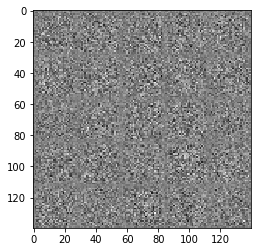

Epoch 1/2... Generator Loss: 0.2864 Discriminator Loss: 2.2216...
Epoch 1/2... Generator Loss: 0.3562 Discriminator Loss: 2.0384...
Epoch 1/2... Generator Loss: 0.9456 Discriminator Loss: 1.1502...
Epoch 1/2... Generator Loss: 0.8642 Discriminator Loss: 0.9929...
Epoch 1/2... Generator Loss: 1.6173 Discriminator Loss: 0.4661...
Epoch 1/2... Generator Loss: 3.1025 Discriminator Loss: 0.0985...
Epoch 1/2... Generator Loss: 3.0888 Discriminator Loss: 0.0869...
Epoch 1/2... Generator Loss: 2.1856 Discriminator Loss: 0.1602...
Epoch 1/2... Generator Loss: 2.7257 Discriminator Loss: 0.2600...
Epoch 1/2... Generator Loss: 2.0455 Discriminator Loss: 0.3074...


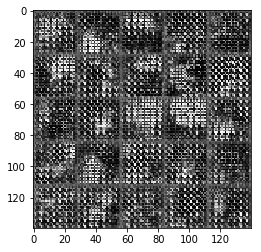

Epoch 1/2... Generator Loss: 3.4631 Discriminator Loss: 0.0943...
Epoch 1/2... Generator Loss: 3.4401 Discriminator Loss: 0.1114...
Epoch 1/2... Generator Loss: 3.1955 Discriminator Loss: 0.0885...
Epoch 1/2... Generator Loss: 3.0285 Discriminator Loss: 0.0920...
Epoch 1/2... Generator Loss: 4.0499 Discriminator Loss: 0.6433...
Epoch 1/2... Generator Loss: 3.9157 Discriminator Loss: 0.8953...
Epoch 1/2... Generator Loss: 2.2333 Discriminator Loss: 0.4864...
Epoch 1/2... Generator Loss: 4.2778 Discriminator Loss: 0.3104...
Epoch 1/2... Generator Loss: 0.1564 Discriminator Loss: 2.5568...
Epoch 1/2... Generator Loss: 6.1004 Discriminator Loss: 2.7128...


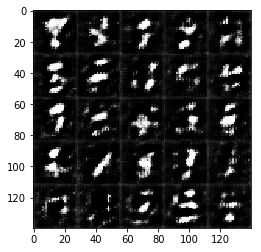

Epoch 1/2... Generator Loss: 0.5874 Discriminator Loss: 1.1216...
Epoch 1/2... Generator Loss: 2.9137 Discriminator Loss: 0.2567...
Epoch 1/2... Generator Loss: 3.0725 Discriminator Loss: 0.1163...
Epoch 1/2... Generator Loss: 2.1105 Discriminator Loss: 0.2208...
Epoch 1/2... Generator Loss: 2.1133 Discriminator Loss: 0.2329...
Epoch 1/2... Generator Loss: 2.1421 Discriminator Loss: 0.1535...
Epoch 1/2... Generator Loss: 3.7867 Discriminator Loss: 0.0482...
Epoch 1/2... Generator Loss: 5.5732 Discriminator Loss: 0.0248...
Epoch 1/2... Generator Loss: 3.1595 Discriminator Loss: 0.0604...
Epoch 1/2... Generator Loss: 3.3526 Discriminator Loss: 0.0678...


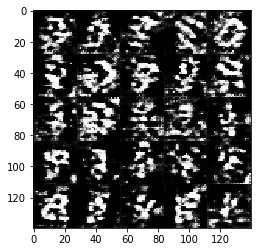

Epoch 1/2... Generator Loss: 2.8516 Discriminator Loss: 0.1048...
Epoch 1/2... Generator Loss: 3.2128 Discriminator Loss: 0.0745...
Epoch 1/2... Generator Loss: 3.5917 Discriminator Loss: 0.0461...
Epoch 1/2... Generator Loss: 4.0512 Discriminator Loss: 0.0273...
Epoch 1/2... Generator Loss: 4.3096 Discriminator Loss: 0.0209...
Epoch 1/2... Generator Loss: 4.2931 Discriminator Loss: 0.0222...
Epoch 1/2... Generator Loss: 4.3839 Discriminator Loss: 0.0208...
Epoch 1/2... Generator Loss: 4.1626 Discriminator Loss: 0.0257...
Epoch 1/2... Generator Loss: 3.1235 Discriminator Loss: 0.0697...
Epoch 1/2... Generator Loss: 0.0905 Discriminator Loss: 2.6084...


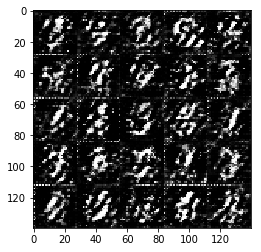

Epoch 1/2... Generator Loss: 6.4890 Discriminator Loss: 0.0870...
Epoch 1/2... Generator Loss: 4.3273 Discriminator Loss: 0.0333...
Epoch 1/2... Generator Loss: 7.3673 Discriminator Loss: 0.0300...
Epoch 1/2... Generator Loss: 2.8128 Discriminator Loss: 0.1078...
Epoch 1/2... Generator Loss: 3.0025 Discriminator Loss: 0.0948...
Epoch 1/2... Generator Loss: 3.1279 Discriminator Loss: 0.0826...
Epoch 2/2... Generator Loss: 3.0779 Discriminator Loss: 0.0774...
Epoch 2/2... Generator Loss: 3.3674 Discriminator Loss: 0.0537...
Epoch 2/2... Generator Loss: 4.6881 Discriminator Loss: 0.0241...
Epoch 2/2... Generator Loss: 4.7332 Discriminator Loss: 0.0240...


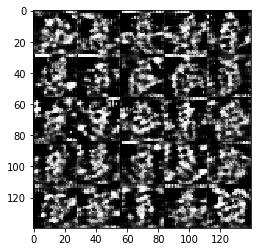

Epoch 2/2... Generator Loss: 1.9532 Discriminator Loss: 0.9883...
Epoch 2/2... Generator Loss: 2.8265 Discriminator Loss: 0.2226...
Epoch 2/2... Generator Loss: 4.4048 Discriminator Loss: 0.3753...
Epoch 2/2... Generator Loss: 1.3382 Discriminator Loss: 0.7264...
Epoch 2/2... Generator Loss: 4.1560 Discriminator Loss: 0.0339...
Epoch 2/2... Generator Loss: 6.2131 Discriminator Loss: 0.9099...
Epoch 2/2... Generator Loss: 0.2343 Discriminator Loss: 1.7832...
Epoch 2/2... Generator Loss: 6.3777 Discriminator Loss: 0.5772...
Epoch 2/2... Generator Loss: 0.6070 Discriminator Loss: 1.0200...
Epoch 2/2... Generator Loss: 6.0435 Discriminator Loss: 0.0466...


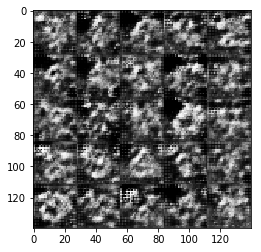

Epoch 2/2... Generator Loss: 2.6594 Discriminator Loss: 0.1736...
Epoch 2/2... Generator Loss: 2.0436 Discriminator Loss: 0.3828...
Epoch 2/2... Generator Loss: 0.4663 Discriminator Loss: 1.3478...
Epoch 2/2... Generator Loss: 1.3488 Discriminator Loss: 0.6494...
Epoch 2/2... Generator Loss: 1.6132 Discriminator Loss: 0.5115...
Epoch 2/2... Generator Loss: 2.1855 Discriminator Loss: 0.5943...
Epoch 2/2... Generator Loss: 0.7576 Discriminator Loss: 0.9149...
Epoch 2/2... Generator Loss: 1.1595 Discriminator Loss: 0.6346...
Epoch 2/2... Generator Loss: 0.7545 Discriminator Loss: 0.9418...
Epoch 2/2... Generator Loss: 3.0075 Discriminator Loss: 1.7221...


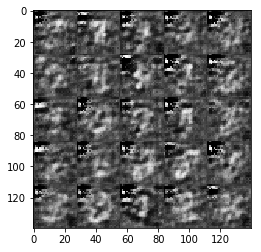

Epoch 2/2... Generator Loss: 1.2302 Discriminator Loss: 0.6942...
Epoch 2/2... Generator Loss: 0.3949 Discriminator Loss: 1.3644...
Epoch 2/2... Generator Loss: 0.3918 Discriminator Loss: 1.3758...
Epoch 2/2... Generator Loss: 0.6757 Discriminator Loss: 1.2294...
Epoch 2/2... Generator Loss: 0.7685 Discriminator Loss: 0.8997...
Epoch 2/2... Generator Loss: 2.2073 Discriminator Loss: 0.5876...
Epoch 2/2... Generator Loss: 1.7564 Discriminator Loss: 0.3088...
Epoch 2/2... Generator Loss: 1.4811 Discriminator Loss: 0.5184...
Epoch 2/2... Generator Loss: 4.7630 Discriminator Loss: 0.7551...
Epoch 2/2... Generator Loss: 0.9058 Discriminator Loss: 0.8541...


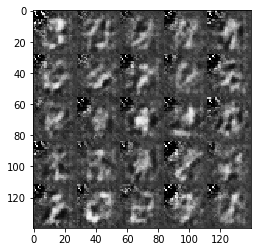

Epoch 2/2... Generator Loss: 1.0463 Discriminator Loss: 0.8376...
Epoch 2/2... Generator Loss: 3.4742 Discriminator Loss: 0.2332...
Epoch 2/2... Generator Loss: 1.9796 Discriminator Loss: 0.4580...
Epoch 2/2... Generator Loss: 2.0330 Discriminator Loss: 0.3383...
Epoch 2/2... Generator Loss: 3.5274 Discriminator Loss: 0.5824...
Epoch 2/2... Generator Loss: 1.6220 Discriminator Loss: 0.3550...
Epoch 2/2... Generator Loss: 0.9236 Discriminator Loss: 0.7622...
Epoch 2/2... Generator Loss: 2.2157 Discriminator Loss: 0.3522...
Epoch 2/2... Generator Loss: 3.2905 Discriminator Loss: 0.1327...
Epoch 2/2... Generator Loss: 0.5726 Discriminator Loss: 1.2947...


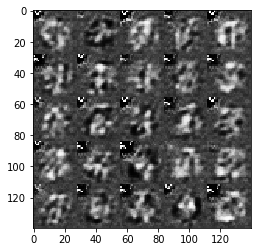

Epoch 2/2... Generator Loss: 2.2309 Discriminator Loss: 0.2494...
Epoch 2/2... Generator Loss: 1.3492 Discriminator Loss: 0.3962...
Epoch 2/2... Generator Loss: 3.1776 Discriminator Loss: 0.5583...


In [97]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

initial output:


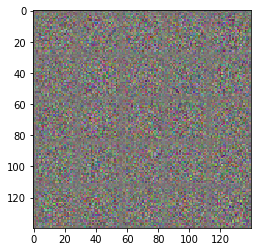

Epoch 1/1... Generator Loss: 0.1999 Discriminator Loss: 3.0746...
Epoch 1/1... Generator Loss: 0.2871 Discriminator Loss: 2.2068...
Epoch 1/1... Generator Loss: 0.5288 Discriminator Loss: 1.9721...
Epoch 1/1... Generator Loss: 0.7912 Discriminator Loss: 1.4209...
Epoch 1/1... Generator Loss: 0.9074 Discriminator Loss: 0.9256...
Epoch 1/1... Generator Loss: 1.6723 Discriminator Loss: 0.5188...
Epoch 1/1... Generator Loss: 1.5455 Discriminator Loss: 0.4672...
Epoch 1/1... Generator Loss: 1.5977 Discriminator Loss: 0.4385...
Epoch 1/1... Generator Loss: 1.9737 Discriminator Loss: 0.2791...
Epoch 1/1... Generator Loss: 2.0992 Discriminator Loss: 0.2226...


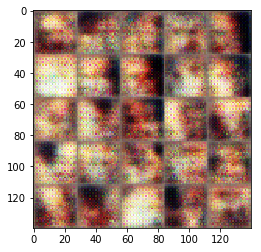

Epoch 1/1... Generator Loss: 5.3981 Discriminator Loss: 1.7428...
Epoch 1/1... Generator Loss: 1.7657 Discriminator Loss: 0.8938...
Epoch 1/1... Generator Loss: 2.1012 Discriminator Loss: 0.5179...
Epoch 1/1... Generator Loss: 1.7798 Discriminator Loss: 0.4994...
Epoch 1/1... Generator Loss: 1.9259 Discriminator Loss: 0.5852...
Epoch 1/1... Generator Loss: 2.9848 Discriminator Loss: 0.9499...
Epoch 1/1... Generator Loss: 2.6373 Discriminator Loss: 0.2194...
Epoch 1/1... Generator Loss: 2.6181 Discriminator Loss: 0.2394...
Epoch 1/1... Generator Loss: 2.6511 Discriminator Loss: 0.2972...
Epoch 1/1... Generator Loss: 2.9493 Discriminator Loss: 0.9954...


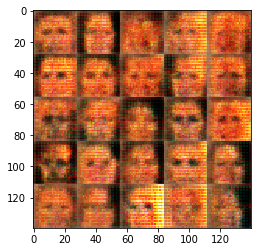

Epoch 1/1... Generator Loss: 2.8164 Discriminator Loss: 0.3308...
Epoch 1/1... Generator Loss: 2.5790 Discriminator Loss: 0.1750...
Epoch 1/1... Generator Loss: 2.7273 Discriminator Loss: 0.2027...
Epoch 1/1... Generator Loss: 2.9695 Discriminator Loss: 0.1927...
Epoch 1/1... Generator Loss: 4.0790 Discriminator Loss: 0.1052...
Epoch 1/1... Generator Loss: 3.5276 Discriminator Loss: 0.1381...
Epoch 1/1... Generator Loss: 3.4580 Discriminator Loss: 0.4315...
Epoch 1/1... Generator Loss: 3.7125 Discriminator Loss: 0.0995...
Epoch 1/1... Generator Loss: 1.9733 Discriminator Loss: 0.2746...
Epoch 1/1... Generator Loss: 2.6690 Discriminator Loss: 0.2037...


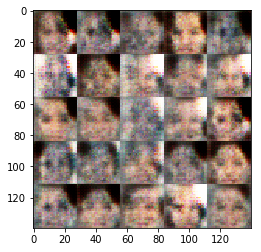

Epoch 1/1... Generator Loss: 3.0575 Discriminator Loss: 0.1927...
Epoch 1/1... Generator Loss: 4.6258 Discriminator Loss: 0.0434...
Epoch 1/1... Generator Loss: 3.9589 Discriminator Loss: 0.0671...
Epoch 1/1... Generator Loss: 3.2662 Discriminator Loss: 0.0660...
Epoch 1/1... Generator Loss: 1.5396 Discriminator Loss: 0.2901...
Epoch 1/1... Generator Loss: 5.6363 Discriminator Loss: 0.2536...
Epoch 1/1... Generator Loss: 1.2289 Discriminator Loss: 0.6266...
Epoch 1/1... Generator Loss: 4.8804 Discriminator Loss: 0.0498...
Epoch 1/1... Generator Loss: 2.7210 Discriminator Loss: 0.3223...
Epoch 1/1... Generator Loss: 3.8727 Discriminator Loss: 0.1627...


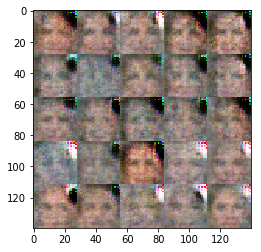

Epoch 1/1... Generator Loss: 1.8379 Discriminator Loss: 0.2395...
Epoch 1/1... Generator Loss: 1.0340 Discriminator Loss: 0.6411...
Epoch 1/1... Generator Loss: 0.2351 Discriminator Loss: 1.9454...
Epoch 1/1... Generator Loss: 0.9533 Discriminator Loss: 0.7078...
Epoch 1/1... Generator Loss: 3.1579 Discriminator Loss: 0.6226...
Epoch 1/1... Generator Loss: 2.9301 Discriminator Loss: 0.2188...
Epoch 1/1... Generator Loss: 3.4308 Discriminator Loss: 0.1726...
Epoch 1/1... Generator Loss: 1.7035 Discriminator Loss: 0.2598...
Epoch 1/1... Generator Loss: 3.6139 Discriminator Loss: 0.0786...
Epoch 1/1... Generator Loss: 1.6192 Discriminator Loss: 0.5982...


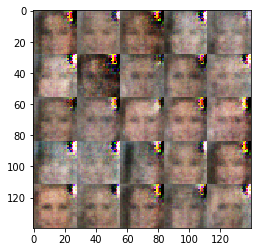

Epoch 1/1... Generator Loss: 2.5943 Discriminator Loss: 0.2294...
Epoch 1/1... Generator Loss: 3.4368 Discriminator Loss: 0.1970...
Epoch 1/1... Generator Loss: 1.1314 Discriminator Loss: 0.4803...
Epoch 1/1... Generator Loss: 3.7686 Discriminator Loss: 0.0385...
Epoch 1/1... Generator Loss: 5.2578 Discriminator Loss: 0.0183...
Epoch 1/1... Generator Loss: 2.5046 Discriminator Loss: 0.1526...
Epoch 1/1... Generator Loss: 2.8461 Discriminator Loss: 0.0956...
Epoch 1/1... Generator Loss: 2.8075 Discriminator Loss: 0.1056...
Epoch 1/1... Generator Loss: 2.4582 Discriminator Loss: 0.1516...
Epoch 1/1... Generator Loss: 4.3503 Discriminator Loss: 0.0469...


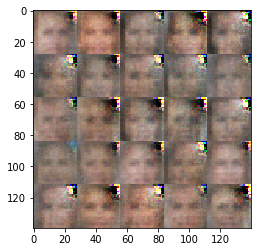

Epoch 1/1... Generator Loss: 3.7422 Discriminator Loss: 0.0771...
Epoch 1/1... Generator Loss: 2.8104 Discriminator Loss: 0.0998...
Epoch 1/1... Generator Loss: 4.7317 Discriminator Loss: 0.0251...
Epoch 1/1... Generator Loss: 3.9870 Discriminator Loss: 0.0280...
Epoch 1/1... Generator Loss: 3.6615 Discriminator Loss: 0.0634...
Epoch 1/1... Generator Loss: 2.7773 Discriminator Loss: 0.0854...
Epoch 1/1... Generator Loss: 4.0671 Discriminator Loss: 0.0435...
Epoch 1/1... Generator Loss: 3.3297 Discriminator Loss: 0.1110...
Epoch 1/1... Generator Loss: 6.8062 Discriminator Loss: 0.0455...
Epoch 1/1... Generator Loss: 6.4948 Discriminator Loss: 1.1478...


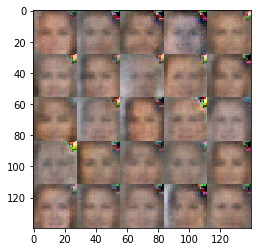

Epoch 1/1... Generator Loss: 1.7652 Discriminator Loss: 0.3501...
Epoch 1/1... Generator Loss: 3.8587 Discriminator Loss: 0.1768...
Epoch 1/1... Generator Loss: 2.4630 Discriminator Loss: 0.1675...
Epoch 1/1... Generator Loss: 4.3745 Discriminator Loss: 0.1852...
Epoch 1/1... Generator Loss: 3.2323 Discriminator Loss: 0.0901...
Epoch 1/1... Generator Loss: 3.1832 Discriminator Loss: 0.0777...
Epoch 1/1... Generator Loss: 3.5966 Discriminator Loss: 0.1174...
Epoch 1/1... Generator Loss: 7.6469 Discriminator Loss: 0.6502...
Epoch 1/1... Generator Loss: 4.2336 Discriminator Loss: 0.0540...
Epoch 1/1... Generator Loss: 5.7634 Discriminator Loss: 0.2576...


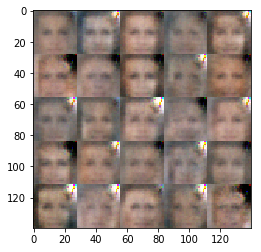

Epoch 1/1... Generator Loss: 2.9158 Discriminator Loss: 0.0951...
Epoch 1/1... Generator Loss: 3.9421 Discriminator Loss: 0.0498...
Epoch 1/1... Generator Loss: 3.3897 Discriminator Loss: 0.0843...
Epoch 1/1... Generator Loss: 4.4191 Discriminator Loss: 0.0385...
Epoch 1/1... Generator Loss: 3.1726 Discriminator Loss: 0.0810...
Epoch 1/1... Generator Loss: 3.9619 Discriminator Loss: 0.0486...
Epoch 1/1... Generator Loss: 3.1559 Discriminator Loss: 0.0758...
Epoch 1/1... Generator Loss: 6.8407 Discriminator Loss: 0.1035...
Epoch 1/1... Generator Loss: 8.8112 Discriminator Loss: 0.0067...
Epoch 1/1... Generator Loss: 3.2052 Discriminator Loss: 0.0890...


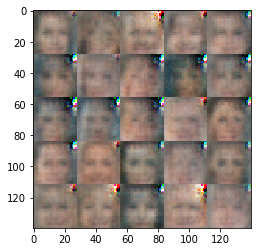

Epoch 1/1... Generator Loss: 4.7536 Discriminator Loss: 0.0178...
Epoch 1/1... Generator Loss: 4.3497 Discriminator Loss: 0.0205...
Epoch 1/1... Generator Loss: 4.1309 Discriminator Loss: 0.0253...
Epoch 1/1... Generator Loss: 5.2184 Discriminator Loss: 0.0331...
Epoch 1/1... Generator Loss: 3.9348 Discriminator Loss: 0.0352...
Epoch 1/1... Generator Loss: 3.1067 Discriminator Loss: 0.0658...
Epoch 1/1... Generator Loss: 9.3977 Discriminator Loss: 0.0508...
Epoch 1/1... Generator Loss: 9.6970 Discriminator Loss: 0.0037...
Epoch 1/1... Generator Loss: 6.1653 Discriminator Loss: 0.0131...
Epoch 1/1... Generator Loss: 5.6806 Discriminator Loss: 0.0142...


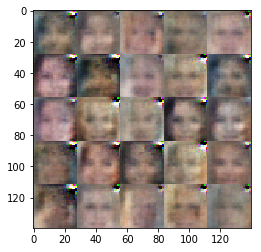

Epoch 1/1... Generator Loss: 6.4481 Discriminator Loss: 0.0108...
Epoch 1/1... Generator Loss: 8.5677 Discriminator Loss: 0.0087...
Epoch 1/1... Generator Loss: 3.4104 Discriminator Loss: 0.0632...
Epoch 1/1... Generator Loss: 4.9597 Discriminator Loss: 0.0266...
Epoch 1/1... Generator Loss: 4.1533 Discriminator Loss: 0.0263...
Epoch 1/1... Generator Loss: 6.1910 Discriminator Loss: 0.0100...
Epoch 1/1... Generator Loss: 4.8880 Discriminator Loss: 0.0153...
Epoch 1/1... Generator Loss: 8.6881 Discriminator Loss: 0.0060...
Epoch 1/1... Generator Loss: 4.8336 Discriminator Loss: 0.0172...
Epoch 1/1... Generator Loss: 12.4540 Discriminator Loss: 0.0085...


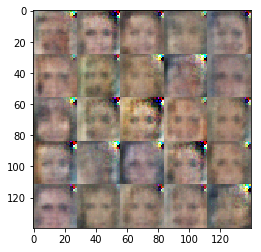

Epoch 1/1... Generator Loss: 4.7252 Discriminator Loss: 0.0146...
Epoch 1/1... Generator Loss: 3.9613 Discriminator Loss: 0.0251...
Epoch 1/1... Generator Loss: 5.9406 Discriminator Loss: 0.0076...
Epoch 1/1... Generator Loss: 7.5166 Discriminator Loss: 0.0076...
Epoch 1/1... Generator Loss: 8.6443 Discriminator Loss: 0.0040...
Epoch 1/1... Generator Loss: 6.2921 Discriminator Loss: 0.0086...
Epoch 1/1... Generator Loss: 3.6956 Discriminator Loss: 0.0329...
Epoch 1/1... Generator Loss: 3.1532 Discriminator Loss: 0.0595...
Epoch 1/1... Generator Loss: 12.8892 Discriminator Loss: 9.3813...
Epoch 1/1... Generator Loss: 2.6155 Discriminator Loss: 0.2343...


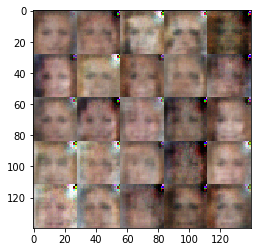

Epoch 1/1... Generator Loss: 1.8611 Discriminator Loss: 0.3407...
Epoch 1/1... Generator Loss: 4.7355 Discriminator Loss: 0.1055...
Epoch 1/1... Generator Loss: 1.2173 Discriminator Loss: 0.6816...
Epoch 1/1... Generator Loss: 2.1291 Discriminator Loss: 0.2871...
Epoch 1/1... Generator Loss: 1.6036 Discriminator Loss: 0.4970...
Epoch 1/1... Generator Loss: 2.4968 Discriminator Loss: 0.1654...
Epoch 1/1... Generator Loss: 0.5124 Discriminator Loss: 1.1150...
Epoch 1/1... Generator Loss: 9.5865 Discriminator Loss: 0.0741...
Epoch 1/1... Generator Loss: 4.3220 Discriminator Loss: 0.0288...
Epoch 1/1... Generator Loss: 2.6203 Discriminator Loss: 0.1183...


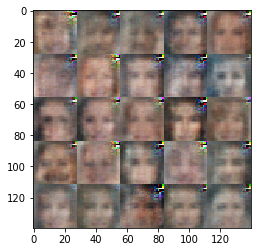

Epoch 1/1... Generator Loss: 4.8991 Discriminator Loss: 0.0334...
Epoch 1/1... Generator Loss: 3.7930 Discriminator Loss: 0.0495...
Epoch 1/1... Generator Loss: 4.3123 Discriminator Loss: 0.0255...
Epoch 1/1... Generator Loss: 3.8183 Discriminator Loss: 0.0412...
Epoch 1/1... Generator Loss: 10.9936 Discriminator Loss: 0.0112...
Epoch 1/1... Generator Loss: 6.7703 Discriminator Loss: 0.0213...
Epoch 1/1... Generator Loss: 5.9918 Discriminator Loss: 0.0094...
Epoch 1/1... Generator Loss: 3.8199 Discriminator Loss: 0.0338...
Epoch 1/1... Generator Loss: 4.3979 Discriminator Loss: 0.0207...
Epoch 1/1... Generator Loss: 4.1369 Discriminator Loss: 0.0273...


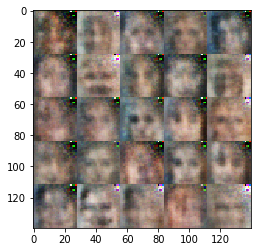

Epoch 1/1... Generator Loss: 8.0953 Discriminator Loss: 0.0067...
Epoch 1/1... Generator Loss: 8.0953 Discriminator Loss: 0.0073...
Epoch 1/1... Generator Loss: 3.5680 Discriminator Loss: 0.0503...
Epoch 1/1... Generator Loss: 5.8253 Discriminator Loss: 0.0069...
Epoch 1/1... Generator Loss: 3.5466 Discriminator Loss: 0.0524...
Epoch 1/1... Generator Loss: 3.6368 Discriminator Loss: 0.0442...
Epoch 1/1... Generator Loss: 4.5111 Discriminator Loss: 0.0157...
Epoch 1/1... Generator Loss: 4.9450 Discriminator Loss: 0.0113...
Epoch 1/1... Generator Loss: 7.1514 Discriminator Loss: 0.0039...
Epoch 1/1... Generator Loss: 4.5136 Discriminator Loss: 0.0172...


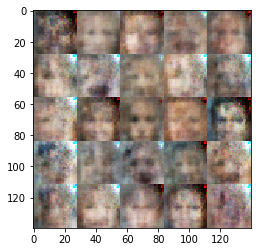

Epoch 1/1... Generator Loss: 4.2169 Discriminator Loss: 0.0224...
Epoch 1/1... Generator Loss: 4.6908 Discriminator Loss: 0.0412...
Epoch 1/1... Generator Loss: 3.3827 Discriminator Loss: 0.0435...
Epoch 1/1... Generator Loss: 6.7857 Discriminator Loss: 0.0062...
Epoch 1/1... Generator Loss: 5.0617 Discriminator Loss: 0.0155...
Epoch 1/1... Generator Loss: 4.8836 Discriminator Loss: 0.0123...
Epoch 1/1... Generator Loss: 6.8774 Discriminator Loss: 0.0060...
Epoch 1/1... Generator Loss: 5.1162 Discriminator Loss: 0.0158...


In [98]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.